In [81]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import datetime
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # Or 2, 3, etc. other than 0

In [82]:
!pip install -q -U toai

You should consider upgrading via the 'pip install --upgrade pip' command.


In [83]:
!pip install -q --no-deps tensorflow-addons==0.6

You should consider upgrading via the 'pip install --upgrade pip' command.


In [84]:
import tensorflow_addons
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
import tensorflow as tf
from tensorflow import keras
from typing import *
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [85]:
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.3.9
2.1.0


In [124]:
DATA_FOLDER = "/tf/data"
LABELS_FILENAME = "photo_ids.csv"
PHOTOS_FOLDER = "images"
TEST_FOLDER = "test_images"

In [125]:
WORKING_DIR = Path(DATA_FOLDER)
PHOTOS_DIR = WORKING_DIR / PHOTOS_FOLDER
TEST_DATA_DIR = WORKING_DIR / TEST_FOLDER
LABELS_FILE = WORKING_DIR / LABELS_FILENAME

In [126]:
photo_files = list(PHOTOS_DIR.glob("*"))

In [127]:
BATCH_SIZE = 32
SHUFFLE_SIZE = 1024
IMG_DIMS = (299, 299, 3)

In [128]:
# list all the files that are corrupted or missing
# load pandas dataframe
# exclude garbage from pandas dataframe

In [129]:
dataframe = pd.read_csv(LABELS_FILE, low_memory=False, names=['uuid', 'price', 'sale'])


In [130]:
@attr.s(auto_attribs=True)
class ImageParser:
    n_channels: int = 3

    def __call__(self, input_data, label: tf.Tensor) -> tf.Tensor:
        filename = input_data[0]
        image = tf.image.decode_jpeg(
            tf.io.read_file(filename), channels=self.n_channels
        )
        image = tf.image.convert_image_dtype(image, tf.float32)
        return (image, input_data[1]), label

In [131]:
@attr.s(auto_attribs=True)
class ImageResizer:
    img_dims: Tuple[int, int, int]
    resize: Optional[str] = None
    crop_adjustment: float = 1

    def __call__(self, input_data, label: tf.Tensor) -> tf.Tensor:
        image = input_data[0]
        height, width, _ = self.img_dims
        if self.resize == "stretch":
            image = tf.image.resize(image, (height, width))
        elif self.resize == "crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(
                images=image, size=(crop_height, crop_width), preserve_aspect_ratio=True
            )
            image = tf.image.resize_with_crop_or_pad(image, height, width)
        elif self.resize == "random_crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(image, (crop_height, crop_width))
            image = tf.image.random_crop(image, self.img_dims)

        return (image, input_data[1]), label

In [132]:
doesnt_exist = []
for index, row in dataframe.iterrows():
    uuid = row["uuid"]
    file = PHOTOS_DIR / uuid
    if not file.exists():
        doesnt_exist.append(index)
        

In [133]:
cleaned_df = dataframe.drop(doesnt_exist)
min_price, max_price = cleaned_df.price.min(), cleaned_df.price.max()
cleaned_df.price = (cleaned_df.price - min_price) / (max_price - min_price)

In [134]:
train_dataframe, test_dataframe = train_test_split(cleaned_df, test_size=0.2)
test_dataframe, validation_dataframe = train_test_split(test_dataframe, test_size=0.5)

In [135]:
train_images_path = str(PHOTOS_DIR) + "/" + train_dataframe["uuid"]
train_data = (
    tf.data.Dataset.from_tensor_slices(((train_images_path , train_dataframe["price"]), train_dataframe["sale"]))
    .map(map_func=ImageParser())
    .map(map_func=ImageResizer(IMG_DIMS, "stretch"))
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [136]:
validation_images_path = str(PHOTOS_DIR) + "/" + validation_dataframe["uuid"]
validation_data = (
    tf.data.Dataset.from_tensor_slices(
        ((validation_images_path, validation_dataframe["price"]), validation_dataframe["sale"]))
    .map(map_func=ImageParser())
    .map(map_func=ImageResizer(IMG_DIMS, "stretch"))
    .repeat()
    .batch(BATCH_SIZE)
)

In [137]:
test_images_path = str(PHOTOS_DIR) + "/" + test_dataframe["uuid"]
test_data = (
    tf.data.Dataset.from_tensor_slices(((test_images_path, test_dataframe["price"]), test_dataframe["sale"]))
    .map(map_func=ImageParser())
    .map(map_func=ImageResizer(IMG_DIMS, "stretch"))
    .repeat()
    .batch(BATCH_SIZE)
)

tf.Tensor(1, shape=(), dtype=int32)
0.0 1.0


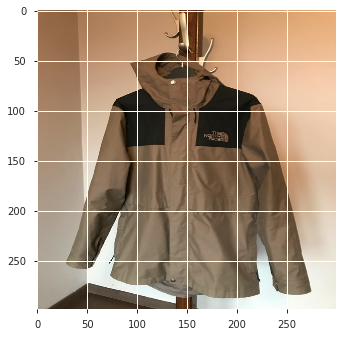

In [138]:
for x, y in validation_data.take(1):
    print(y[0])
    print(x[0].numpy().min(), x[0].numpy().max())
    plt.imshow(x[0].numpy()[0])

In [179]:
Improvements
    * Xception with removed last layer
    * 64 node dense net accepting an image embedding and price
    * 50% dropout layer followed by batch normalization
    * Final dense layer for classification
    * Fine tuning applied afterwards for last 5 layers of Xception

IndentationError: unexpected indent (<ipython-input-179-c5fb1c202b0b>, line 2)

In [140]:
def build_model():
    price_input = tf.keras.Input(shape=(1), name='price')
    price_features = tf.keras.layers.Dense(64, activation='relu')(price_input)
    xception = tf.keras.applications.Xception(include_top=False, pooling='max', weights ='imagenet')
    xception.trainable = False
    concatenated_input = tf.keras.layers.concatenate([price_features, xception.output])
    x = tf.keras.layers.Dense(64, activation="relu", kernel_initializer="glorot_uniform")(concatenated_input)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    prediction = tf.keras.layers.Dense(1, kernel_initializer="glorot_uniform", activation=keras.activations.sigmoid)(x)
    return tf.keras.Model([xception.input, price_input], outputs=[prediction]), xception
    

In [141]:
model, xception = build_model()

In [162]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy', keras.metrics.AUC()])

In [163]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [164]:
model.fit(
    train_data,
    epochs=10,
    validation_data=validation_data,
    steps_per_epoch=math.ceil(train_dataframe.shape[0] / BATCH_SIZE),
    validation_steps=math.ceil(validation_dataframe.shape[0] / BATCH_SIZE),
    callbacks=[tensorboard_callback]
)

Train for 497 steps, validate for 63 steps
Epoch 1/10
497/497 [==============================] - 100s 202ms/step - loss: 0.6796 - accuracy: 0.5656 - auc_4: 0.5950 - val_loss: 0.6934 - val_accuracy: 0.5481 - val_auc_4: 0.5839
Epoch 2/10
497/497 [==============================] - 89s 178ms/step - loss: 0.6663 - accuracy: 0.5912 - auc_4: 0.6293 - val_loss: 0.6911 - val_accuracy: 0.5595 - val_auc_4: 0.5964
Epoch 3/10
497/497 [==============================] - 87s 175ms/step - loss: 0.6563 - accuracy: 0.6069 - auc_4: 0.6543 - val_loss: 0.6906 - val_accuracy: 0.5729 - val_auc_4: 0.6089
Epoch 4/10
497/497 [==============================] - 89s 178ms/step - loss: 0.6408 - accuracy: 0.6295 - auc_4: 0.6815 - val_loss: 0.7282 - val_accuracy: 0.5650 - val_auc_4: 0.5971
Epoch 5/10
497/497 [==============================] - 88s 177ms/step - loss: 0.6272 - accuracy: 0.6441 - auc_4: 0.7042 - val_loss: 0.6840 - val_accuracy: 0.5680 - val_auc_4: 0.6048
Epoch 6/10
497/497 [==============================]

In [161]:
for layer in xception.layers[-5:]:
    layer.trainable = True

In [176]:
test_image_paths = [str (path) for path in TEST_DATA_DIR.glob("*")]
loaded_images = [mpimg.imread(url) for url in test_image_paths]
fake_labels = np.repeat(0, 4)
test_imgs = (
    tf.data.Dataset.from_tensor_slices(((test_image_paths, np.repeat(20, 4)), fake_labels))
    .map(map_func=ImageParser())
    .map(map_func=ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
)
results = [float(score) for score in model.predict(test_imgs).flatten()]
min_result, max_result = min(results), max(results)
normalized_results = [(result - min_result) / (max_result - min_result) for result in results]
result_tuples = list(zip(loaded_images, results))
result_tuples = sorted(result_tuples, key=lambda x: x[1], reverse = True)

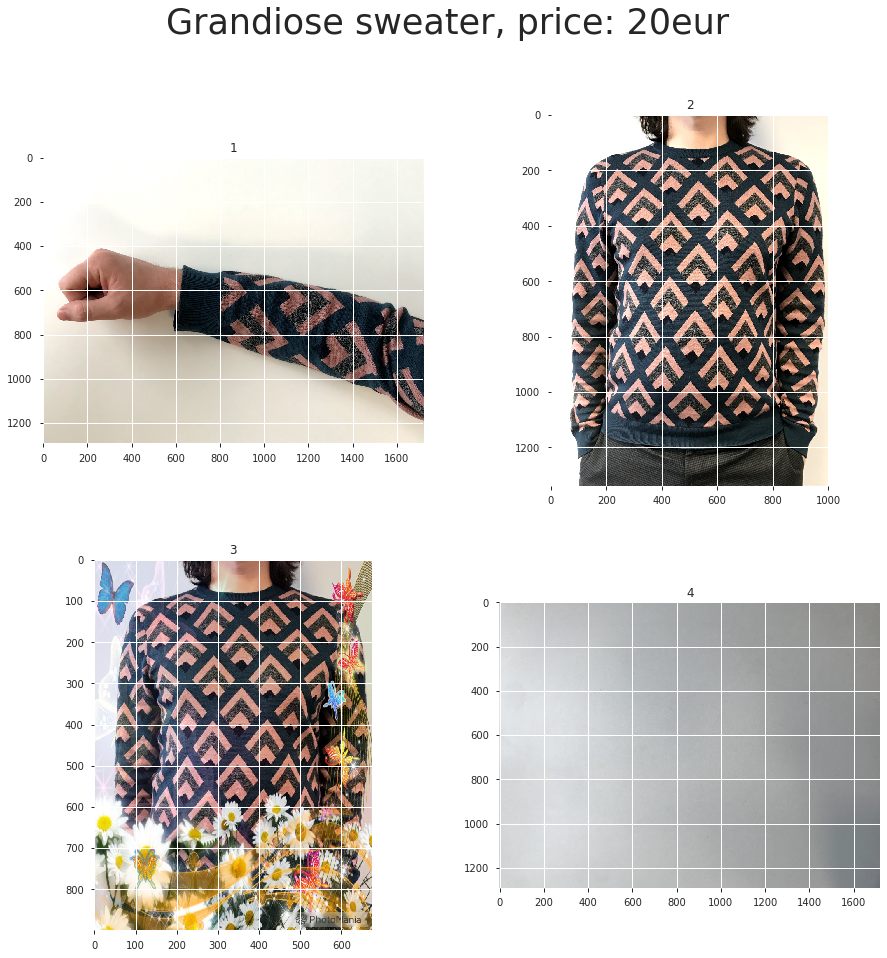

In [185]:
fig = plt.figure(figsize=(15,15))
fig.suptitle("Grandiose sweater, price: 20eur", fontsize=35)
for i in range(4):
    a = fig.add_subplot(221 + i)
    a.imshow(result_tuples[i][0])
    a.title.set_text(i+1)